In [7]:
# Standard imports
import os, sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure src/ is on path (robust: walk up until repo root is found)
def find_project_root(start: Path, markers=("src", "data")) -> Path:
    p = start.resolve()
    for _ in range(6):  # walk up to 6 levels max
        if all((p / m).exists() for m in markers):
            return p
        p = p.parent
    return start.resolve()

try:
    start_here = Path(__file__).resolve()
except NameError:
    start_here = Path.cwd()

ROOT = find_project_root(start_here)
SRC = ROOT / "src"
if SRC.exists() and str(SRC) not in sys.path:
    sys.path.append(str(SRC))

print("ROOT set to:", ROOT)


ROOT set to: C:\Users\beall\OneDrive\Documents\Resume\Portfolio\msaba-01-churn-prediction-logit


In [8]:
from churn.preprocess import load_churn_data
df = load_churn_data(ROOT)
df.head()


,customer_id,signup_dt,age,segment,region,plan,is_veteran,month,support_calls,support_tickets,product_usage_hours,received_promo,churned,tenure_days,tenure_months,logins_last_30d,avg_session_min,support_tickets_last_90d,nps_score
0,100000,2024-10-23,59,Consumer,Central,Basic,0,3/1/2025,5,0,92.835435,0,0,324,10.8,0,0,0,0
1,100000,2024-10-23,59,Consumer,Central,Basic,0,4/1/2025,7,0,81.200638,0,0,324,10.8,0,0,0,0
2,100000,2024-10-23,59,Consumer,Central,Basic,0,5/1/2025,3,0,96.033043,0,0,324,10.8,0,0,0,0
3,100000,2024-10-23,59,Consumer,Central,Basic,0,6/1/2025,3,1,80.568979,0,0,324,10.8,0,0,0,0
4,100000,2024-10-23,59,Consumer,Central,Basic,0,7/1/2025,1,0,63.861343,0,0,324,10.8,0,0,0,0


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Optional: seaborn makes split plots easier (skip if you prefer pure matplotlib)
import seaborn as sns
sns.set_context("talk")


In [10]:
TARGET = "churned"

# Exclude ID/date/target
exclude = {TARGET, "customer_id", "signup_dt", "tenure_bucket"}

num_cols_all = df.select_dtypes(include=[np.number]).columns.difference(exclude)
cat_cols_all = df.columns.difference(exclude.union(set(num_cols_all)))

num_cols_all = list(num_cols_all)
cat_cols_all = list(cat_cols_all)

num_cols_all, cat_cols_all


(['age',
  'avg_session_min',
  'is_veteran',
  'logins_last_30d',
  'nps_score',
  'product_usage_hours',
  'received_promo',
  'support_calls',
  'support_tickets',
  'support_tickets_last_90d',
  'tenure_days',
  'tenure_months'],
 ['month', 'plan', 'region', 'segment'])

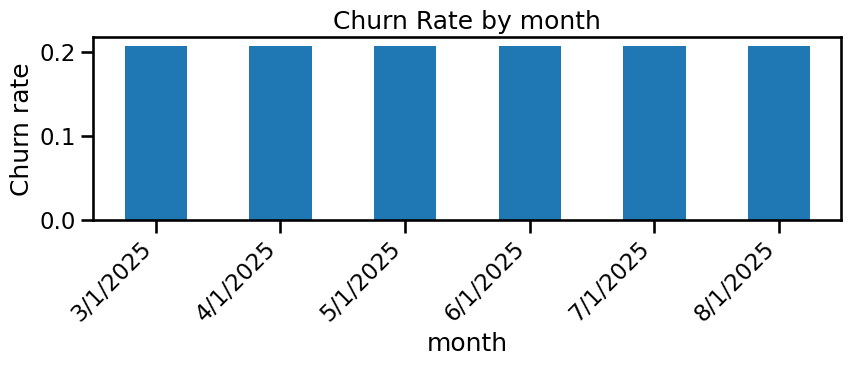

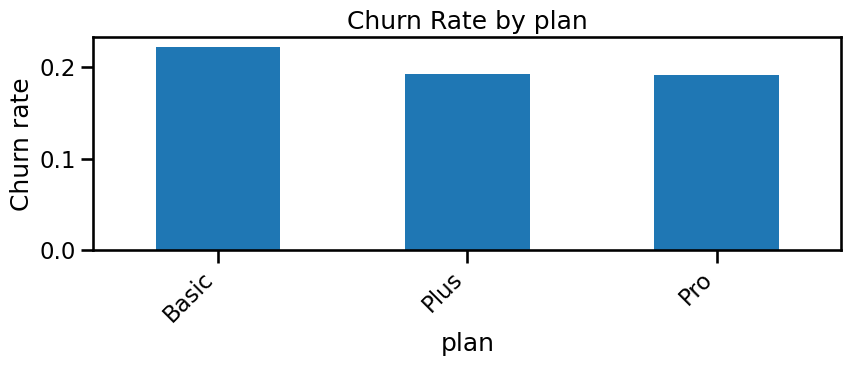

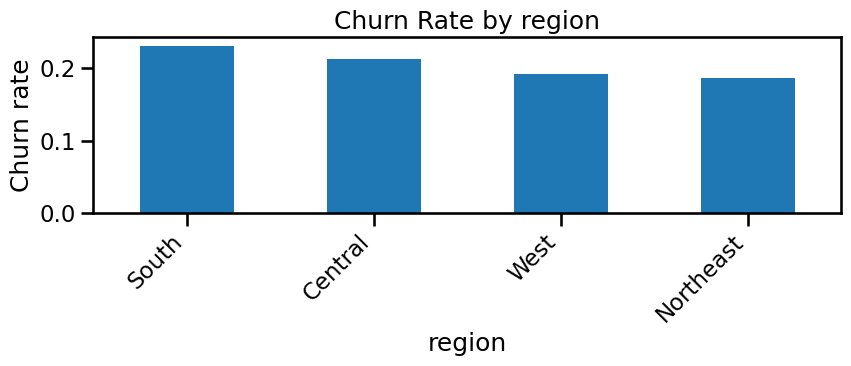

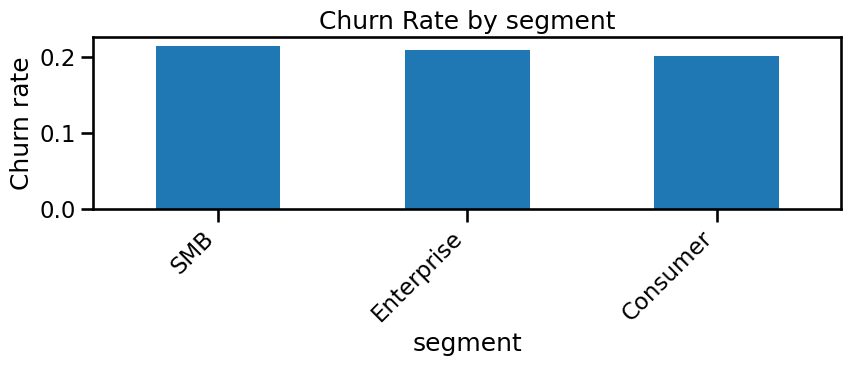

In [11]:
def plot_churn_rate_by_category(data, col, min_count=30, max_levels=20):
    c = data.copy()
    # Drop NA for grouping; keep a label for NA if you prefer:
    # c[col] = c[col].astype("object").fillna("<<MISSING>>")
    c = c.dropna(subset=[col])

    # Collapse long tails: keep top frequent levels
    value_counts = c[col].value_counts()
    keep_levels = value_counts.head(max_levels).index
    c[col] = np.where(c[col].isin(keep_levels), c[col], "<<OTHER>>")

    # Filter out very tiny groups to avoid noisy rates
    grp = c.groupby(col)[TARGET].agg(["mean", "count"]).sort_values("mean", ascending=False)
    grp = grp[grp["count"] >= min_count]

    if grp.empty:
        print(f"[{col}] skipped (too few observations per level).")
        return grp

    ax = grp["mean"].plot(kind="bar", figsize=(9,4))
    ax.set_title(f"Churn Rate by {col}")
    ax.set_ylabel("Churn rate")
    ax.set_xlabel(col)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
    return grp

cat_summaries = {}
for col in cat_cols_all:
    try:
        cat_summaries[col] = plot_churn_rate_by_category(df, col)
    except Exception as e:
        print(f"Error on {col}: {e}")


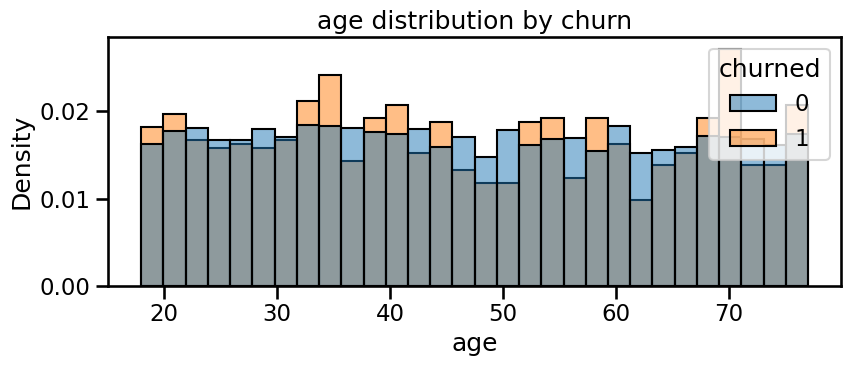

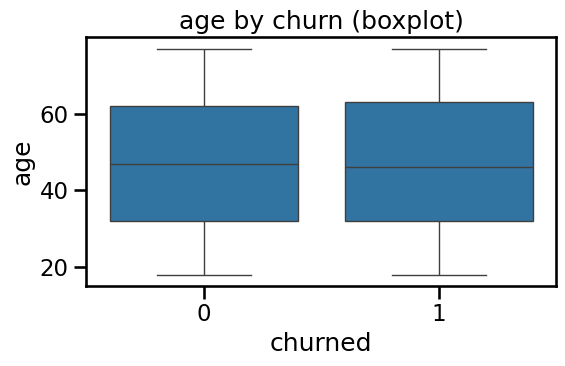

churned,0,1
count,23802.000000,6198.000000
mean,47.140660,47.103582
std,17.324725,17.636311
min,18.000000,18.000000
25%,32.000000,32.000000
50%,47.000000,46.000000
75%,62.000000,63.000000
max,77.000000,77.000000


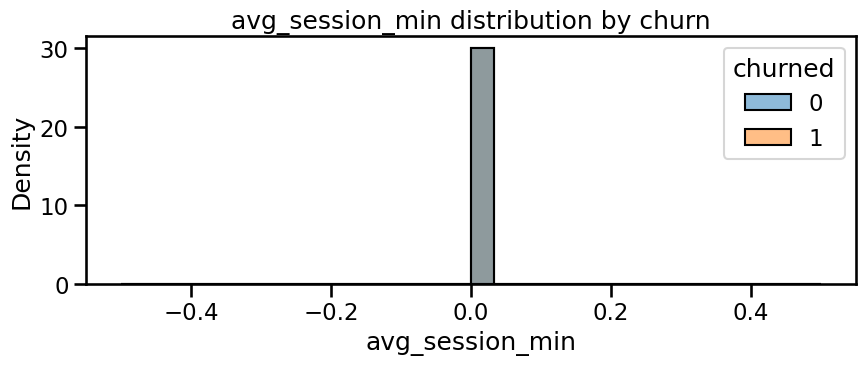

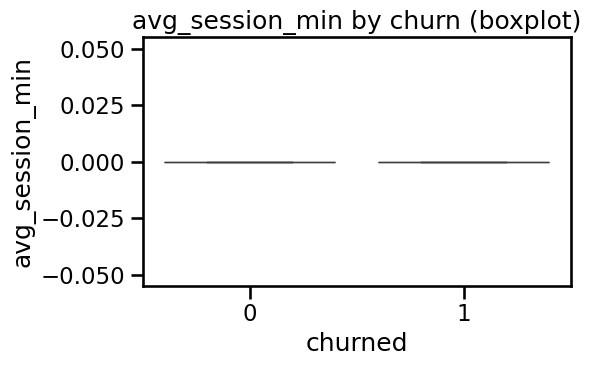

churned,0,1
count,23802.0,6198.0
mean,0.0,0.0
std,0.0,0.0
min,0.0,0.0
25%,0.0,0.0
50%,0.0,0.0
75%,0.0,0.0
max,0.0,0.0


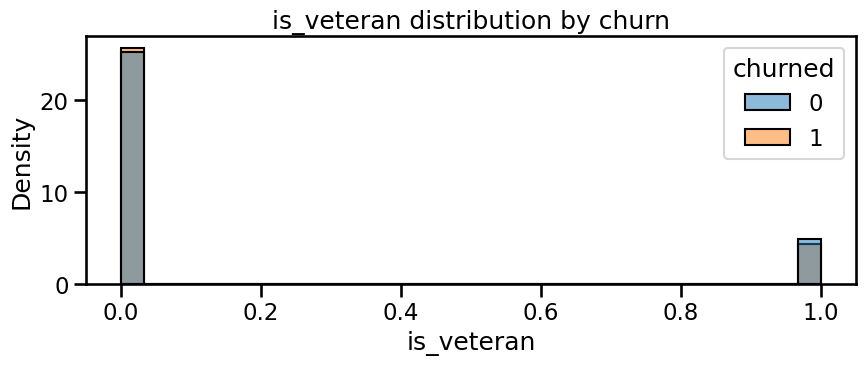

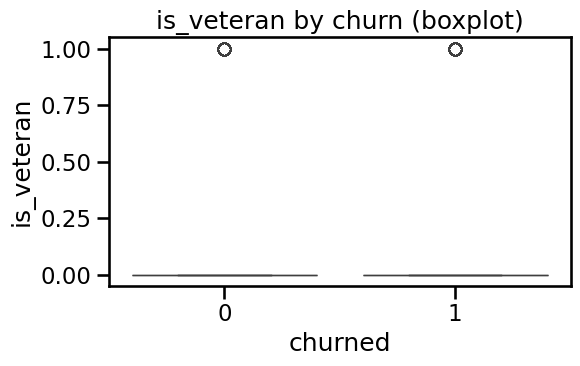

churned,0,1
count,23802.000000,6198.000000
mean,0.161583,0.146176
std,0.368076,0.353311
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1.000000


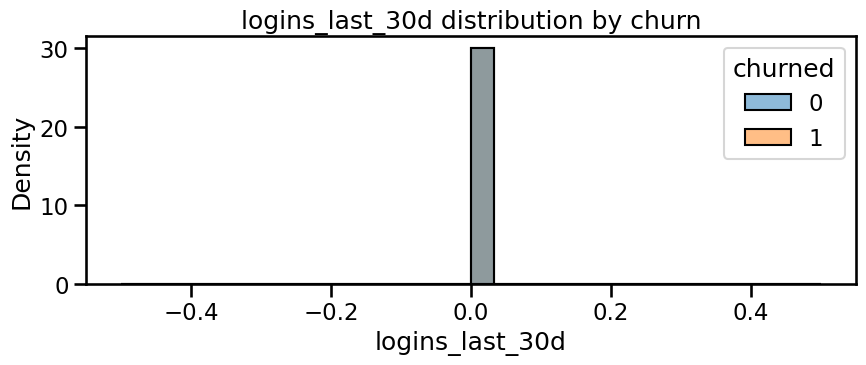

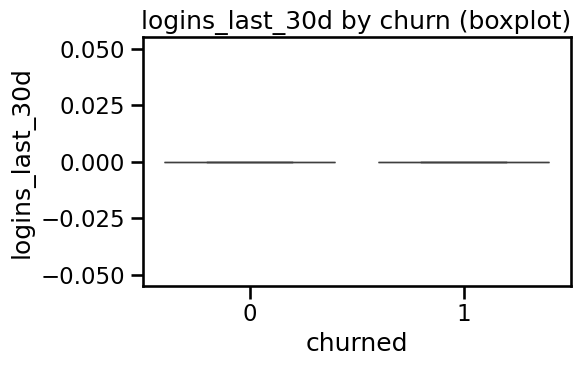

churned,0,1
count,23802.0,6198.0
mean,0.0,0.0
std,0.0,0.0
min,0.0,0.0
25%,0.0,0.0
50%,0.0,0.0
75%,0.0,0.0
max,0.0,0.0


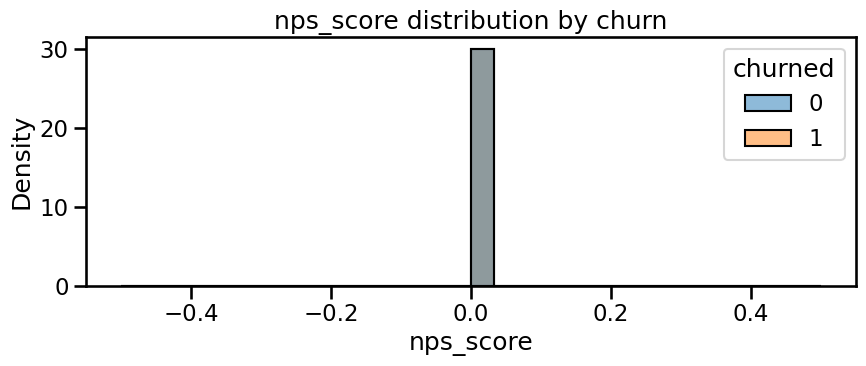

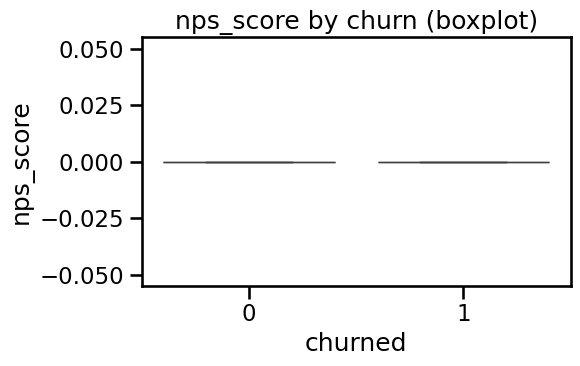

churned,0,1
count,23802.0,6198.0
mean,0.0,0.0
std,0.0,0.0
min,0.0,0.0
25%,0.0,0.0
50%,0.0,0.0
75%,0.0,0.0
max,0.0,0.0


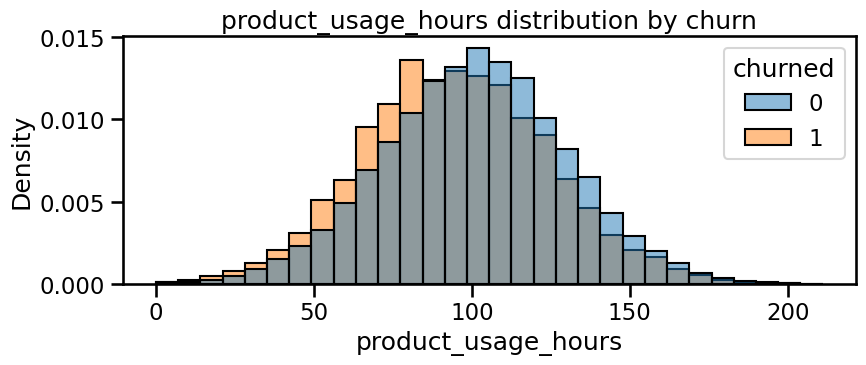

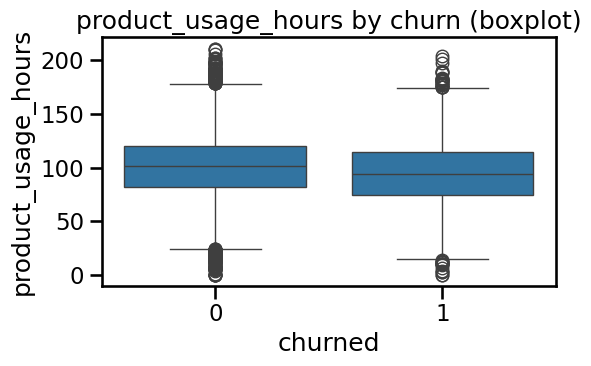

churned,0,1
count,23802.000000,6198.000000
mean,101.059122,94.761869
std,29.130727,29.483699
min,0.000000,0.000000
25%,81.668396,74.436540
50%,101.210018,94.256639
75%,120.317863,114.479194
max,211.049320,204.492014


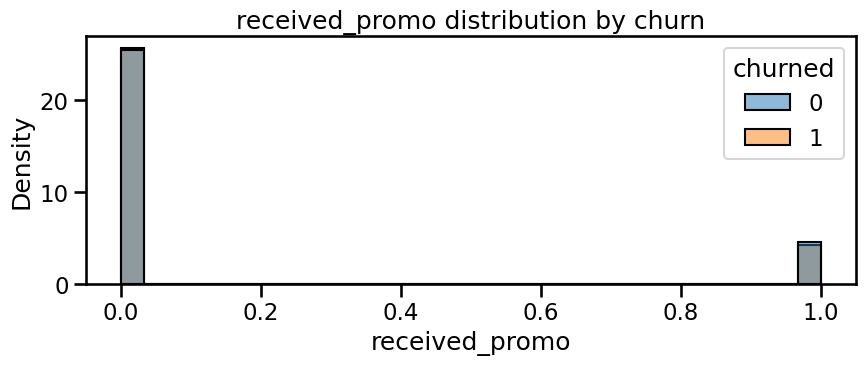

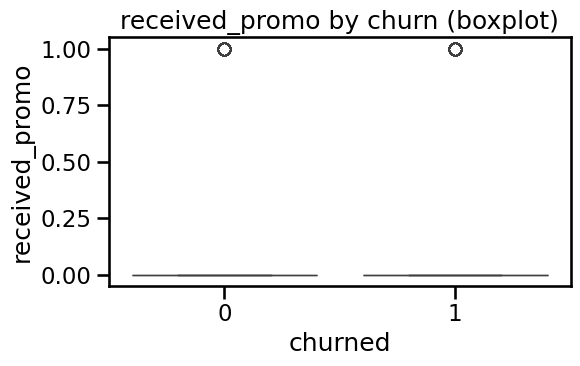

churned,0,1
count,23802.000000,6198.000000
mean,0.151164,0.143595
std,0.358216,0.350707
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1.000000


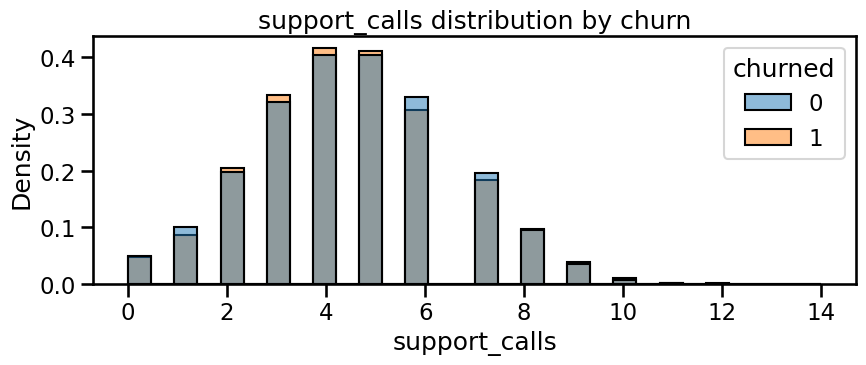

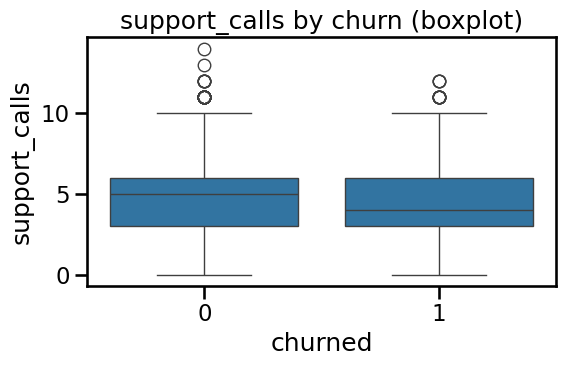

churned,0,1
count,23802.000000,6198.000000
mean,4.497059,4.493869
std,2.000843,2.006817
min,0.000000,0.000000
25%,3.000000,3.000000
50%,5.000000,4.000000
75%,6.000000,6.000000
max,14.000000,12.000000


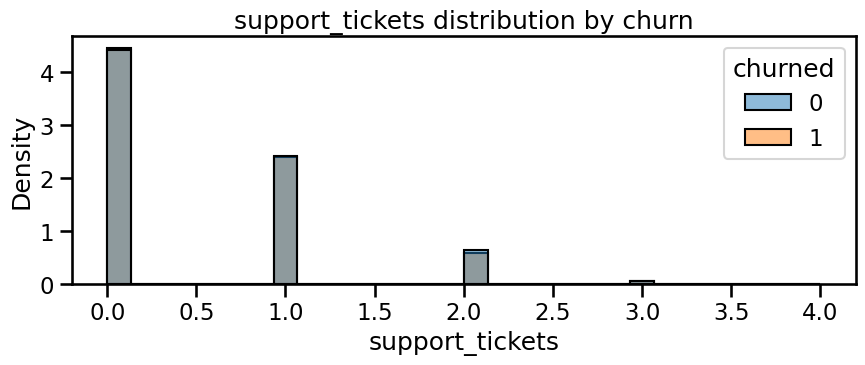

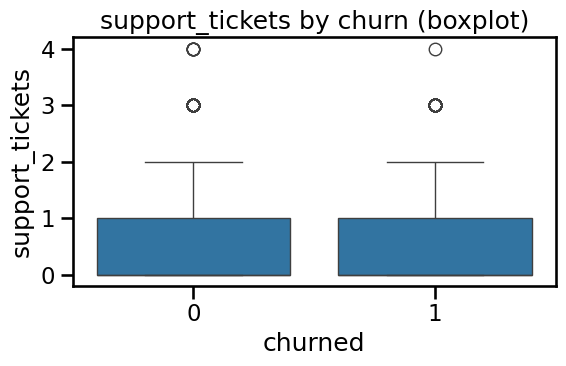

churned,0,1
count,23802.000000,6198.000000
mean,0.511596,0.504356
std,0.680671,0.679512
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,1.000000
max,4.000000,4.000000


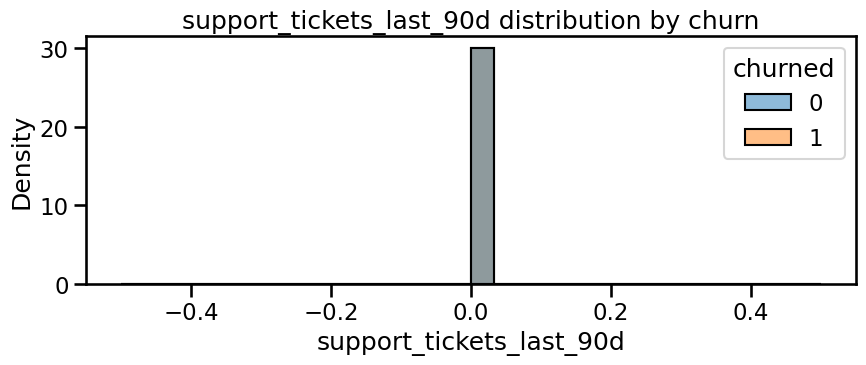

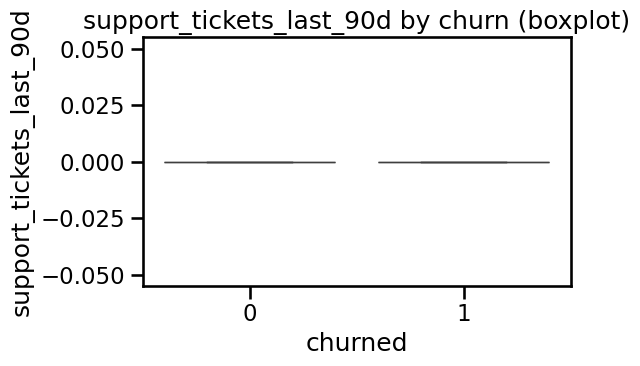

churned,0,1
count,23802.0,6198.0
mean,0.0,0.0
std,0.0,0.0
min,0.0,0.0
25%,0.0,0.0
50%,0.0,0.0
75%,0.0,0.0
max,0.0,0.0


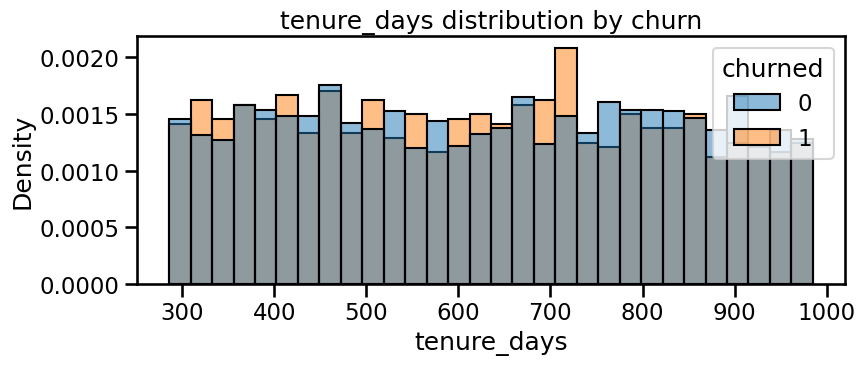

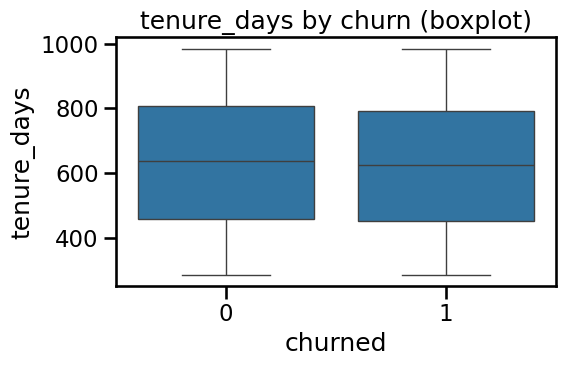

churned,0,1
count,23802.000000,6198.000000
mean,634.052937,624.044530
std,201.013883,198.348845
min,286.000000,286.000000
25%,457.000000,453.000000
50%,637.000000,626.000000
75%,809.000000,792.000000
max,985.000000,985.000000


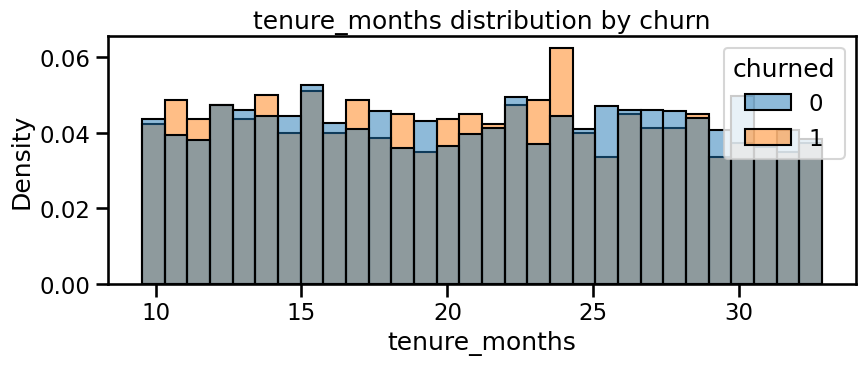

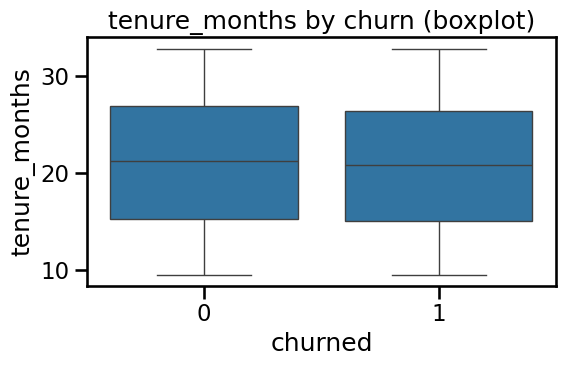

churned,0,1
count,23802.000000,6198.000000
mean,21.135098,20.801484
std,6.700463,6.611628
min,9.533333,9.533333
25%,15.233333,15.100000
50%,21.233333,20.866667
75%,26.966667,26.400000
max,32.833333,32.833333


In [12]:
def plot_numeric_by_churn(data, col, bins=30):
    c = data[[col, TARGET]].dropna()
    if c.empty:
        print(f"[{col}] skipped (no data).")
        return

    # Histogram split by churn
    plt.figure(figsize=(9,4))
    sns.histplot(data=c, x=col, hue=TARGET, bins=bins, stat="density", common_norm=False)
    plt.title(f"{col} distribution by churn")
    plt.tight_layout()
    plt.show()

    # Boxplot split by churn
    plt.figure(figsize=(6,4))
    sns.boxplot(data=c, x=TARGET, y=col)
    plt.title(f"{col} by churn (boxplot)")
    plt.tight_layout()
    plt.show()

    # Simple stats
    grp = c.groupby(TARGET)[col].describe().T
    display(grp)

for col in num_cols_all:
    try:
        plot_numeric_by_churn(df, col)
    except Exception as e:
        print(f"Error on {col}: {e}")


In [13]:
corr_with_churn = (
    df[[TARGET] + num_cols_all]
    .corr(numeric_only=True)[TARGET]
    .drop(TARGET)
    .sort_values(ascending=False)
    .to_frame("corr_with_churn")
)
corr_with_churn


,corr_with_churn
support_calls,-0.000645
age,-0.000863
support_tickets,-0.004308
received_promo,-0.008592
is_veteran,-0.017084
tenure_months,-0.020210
tenure_days,-0.020210
product_usage_hours,-0.086973
avg_session_min,NaN
logins_last_30d,NaN


C:\Users\beall\AppData\Local\Temp\ipykernel_20120\1450634037.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ax = df.groupby("tenure_bucket")[TARGET].mean().plot(kind="bar", figsize=(6,4))


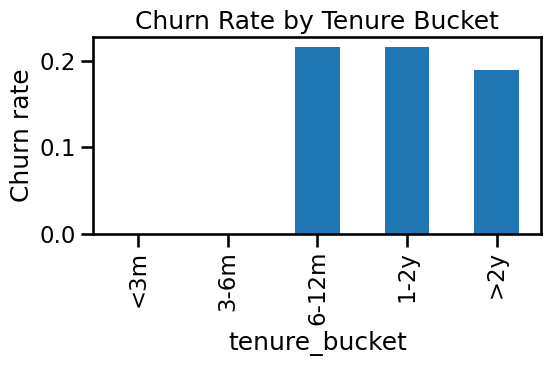

Saved: C:\Users\beall\OneDrive\Documents\Resume\Portfolio\msaba-01-churn-prediction-logit\reports\figures\churn_rate_by_tenure_bucket.png


In [14]:
from pathlib import Path
figdir = (ROOT / "reports" / "figures")
figdir.mkdir(parents=True, exist_ok=True)

# Example: save churn by tenure bucket
if "tenure_days" in df.columns:
    df["tenure_bucket"] = pd.cut(df["tenure_days"],
                                 bins=[0,90,180,365,730,2000],
                                 labels=["<3m","3-6m","6-12m","1-2y",">2y"])
    ax = df.groupby("tenure_bucket")[TARGET].mean().plot(kind="bar", figsize=(6,4))
    ax.set_title("Churn Rate by Tenure Bucket")
    ax.set_ylabel("Churn rate")
    plt.tight_layout()
    outpath = figdir / "churn_rate_by_tenure_bucket.png"
    plt.savefig(outpath, dpi=150)
    plt.show()
    print("Saved:", outpath)


In [ ]:
import sys, platform, pandas as pd, numpy as np
print(sys.executable, platform.python_version(), pd.__version__, np.__version__)


In [1]:
import sys, platform
print(sys.executable)
print(platform.python_version())


c:\Users\beall\miniconda3\envs\ai-scm-portfolio\python.exe
3.11.13


In [2]:
import sys, platform, pandas as pd, numpy as np
print("PY:",sys.executable, platform.python_version())
print("PD:", pd.__version__)
print("NP:", np.__version__)


PY: c:\Users\beall\miniconda3\envs\ai-scm-portfolio\python.exe 3.11.13
PD: 2.3.2
NP: 2.2.6
